In [1]:
import numpy as np
import pandas as pd
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In [2]:
# Neighborhoods in Mexico City
cdmx_cols = pd.read_csv('/Users/rogeliomj/Documents/Coursera_Capstone/Colonias/coloniascdmx.csv', sep=';')

In [3]:
cdmx_cols.head()

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,LOMAS DE REFORMA,9.0,"19.4016815485,-99.2354719599","{""type"": ""Polygon"", ""coordinates"": [[[-99.2359...",16,MIGUEL HIDALGO,16-043,"4971, 4983",NaN
1,DANIEL GARZA (AMPL),9.0,"19.4092184712,-99.1938392453","{""type"": ""Polygon"", ""coordinates"": [[[-99.1932...",16,MIGUEL HIDALGO,16-025,"4951, 4952, 4953","4957, 4959, 4960, 4973, 4990"
2,IGNACIO MANUEL ALTAMIRANO,9.0,"19.4631440514,-99.1968280035","{""type"": ""Polygon"", ""coordinates"": [[[-99.1966...",16,MIGUEL HIDALGO,16-034,NaN,5110
3,LEGARIA,9.0,"19.4555305454,-99.1930482732","{""type"": ""Polygon"", ""coordinates"": [[[-99.1905...",16,MIGUEL HIDALGO,16-036,5046,"5038, 5045, 5058"
4,LEGARIA (U HAB),9.0,"19.450020036,-99.2010760751","{""type"": ""Polygon"", ""coordinates"": [[[-99.2024...",16,MIGUEL HIDALGO,16-037,NaN,"5069, 5070"


In [4]:
neighborhoods = cdmx_cols[cdmx_cols['ALCALDIA'] == 'ALVARO OBREGON']
neighborhoods = neighborhoods[['ALCALDIA','COLONIA','Geo Point']]
neighborhoods.reset_index(drop=True, inplace=True)

In [5]:
geops = neighborhoods['Geo Point'].str.split(pat=',', expand=True)
neighborhoods = pd.concat([neighborhoods,geops], axis=1)
neighborhoods.drop('Geo Point', axis=1, inplace=True)
neighborhoods.rename(columns={'ALCALDIA':'District','COLONIA':'Neighborhood',0:'Latitude',1:'Longitude'}, inplace=True)
neighborhoods['Latitude'] = neighborhoods['Latitude'].astype('float')
neighborhoods['Longitude'] = neighborhoods['Longitude'].astype('float')

In [6]:
neighborhoods.head()

,District,Neighborhood,Latitude,Longitude
0,ALVARO OBREGON,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207
1,ALVARO OBREGON,ESTADO DE HIDALGO_,19.364444,-99.241681
2,ALVARO OBREGON,SAN CLEMENTE,19.349309,-99.226218
3,ALVARO OBREGON,VILLA SOLIDARIDAD,19.383402,-99.219292
4,ALVARO OBREGON,TEPOPOTLA,19.362128,-99.251763


In [7]:
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 4 columns):
District        249 non-null object
Neighborhood    249 non-null object
Latitude        249 non-null float64
Longitude       249 non-null float64
dtypes: float64(2), object(2)
memory usage: 7.9+ KB


In [8]:
# create map of Mexico City using latitude and longitude values

latitude = 19.340995
longitude = -99.249742

map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='OpenStreetMap')

# add markers to map
for lat, lng, district, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], 
                                            neighborhoods['District'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
    
map_cdmx

In [9]:
CLIENT_ID = 'X2BOT3ZFC3IHF0QVIQ4ZDRZC2BQBGYXOUI05KCTTS2QVUNDG' # your Foursquare ID
CLIENT_SECRET = '5IQ2I3LIBVSMU5FDBJZYZJWFVKVENIDHUGUBUD20W3H5FMXW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X2BOT3ZFC3IHF0QVIQ4ZDRZC2BQBGYXOUI05KCTTS2QVUNDG
CLIENT_SECRET:5IQ2I3LIBVSMU5FDBJZYZJWFVKVENIDHUGUBUD20W3H5FMXW


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius


In [12]:
ao_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

2DA  JALALPA TEPITO (AMPL)
ESTADO DE HIDALGO_
SAN CLEMENTE
VILLA SOLIDARIDAD
TEPOPOTLA
PASEO DE LAS LOMAS-SAN GABRIEL
PRESIDENTES 2DA (AMPL)
LOS GAMITOS
LOMAS DE SANTO DOMINGO
LOMAS DE CENTENARIO (U HAB)
CANUTILLO(AGUASCALIENTES)
AGUILAS PILARES
JALALPA TEPITO
EL BATAN
BELEN DE LAS FLORES
LOMAS DE AXOMIATLA
LA PERA XOCHINAHUAC (U HAB)
MOLINO DE ROSAS
LOMAS DE LOS CEDROS
19 DE MAYO
SAN PEDRO DE LOS PINOS
SANTA LUCIA (PBLO)
PARAJE EL CABALLITO
ACUEDUCTO
SANTA MARIA NONOALCO
PRADOS LA PROVIDENCIA
SEARS ROEBUCK (U HAB)
LOMAS DE GUADALUPE
LOMAS DE CHAMONTOYA
MINAS DE CRISTO
LOMAS DE CAPULIN
MARIA G DE GARCIA RUIZ
LOMAS DE LOS ANGELES TETELPAN
MOLINO DE ROSAS (AMPL)
BARRIO NORTE
CANUTILLO 3RA SECCION
TETELPAN (PBLO)
TEPEACA
JALALPA EL GRANDE
LA CONCHITA
GALEANA
LA LOMA
LIBERACION PROLETARIA
CALZADA JALALPA
EL ARBOL
CAADA DEL OLIVAR (U HAB)
OLIVAR DE LOS PADRES
MILPA DEL CEDRO
GOLONDRINAS
EMANCIPACION DEL PUEBLO
PALMAS
SAN ANGEL INN
PUENTE COLORADO
TARANGO (U HAB)
1RA VICTORIA SECCION BOSQUES

In [13]:
print(ao_venues.shape)
ao_venues.head(10)

(4179, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,Campo De Futbol Jalalpa,19.374624,-99.237177,Soccer Field
1,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,La Michoacana,19.371645,-99.232556,Ice Cream Shop
2,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,El Duende,19.371489,-99.231661,Scenic Lookout
3,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,Carnitas Nacho,19.371821,-99.230726,Taco Place
4,ESTADO DE HIDALGO_,19.364444,-99.241681,Starbucks,19.365002,-99.243963,Coffee Shop
5,ESTADO DE HIDALGO_,19.364444,-99.241681,Carnitas Tamaulipas 1190,19.365284,-99.243888,Taco Place
6,ESTADO DE HIDALGO_,19.364444,-99.241681,"La Salle, Unidad Deportiva Santa Lucia",19.366259,-99.240364,Soccer Field
7,ESTADO DE HIDALGO_,19.364444,-99.241681,El Lago de los Patos,19.364521,-99.245345,Taco Place
8,ESTADO DE HIDALGO_,19.364444,-99.241681,La Barda,19.364603,-99.245235,Burger Joint
9,SAN CLEMENTE,19.349309,-99.226218,Santa Clara,19.349067,-99.226417,Ice Cream Shop


In [14]:
print('There are {} uniques categories.'.format(len(ao_venues['Venue Category'].unique())))

There are 245 uniques categories.


# Analyze each neighboorhood (Only Foursquare Data)

In [15]:
# one hot encoding
ao_onehot = pd.get_dummies(ao_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ao_onehot['Neighborhood'] = ao_venues['Neighborhood'] 

In [16]:
ao_onehot.head()

,ATM,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Wine Bar,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [17]:
ao_grouped = ao_onehot.groupby('Neighborhood').mean().reset_index()
ao_grouped

,Neighborhood,ATM,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Wine Bar,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,19 DE MAYO,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,1RA VICTORIA,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,1RA VICTORIA SECCION BOSQUES,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,26 DE JULIO,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,2DA JALALPA TEPITO (AMPL),0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,2DA EL PIRUL (AMPL),0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,ABRAHAM GONZALEZ,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,ACUEDUCTO,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.055556,0.0,0.000000,0.0,0.000000
8,ACUILOTLA,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,AGUILAS 3ER PARQUE,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [18]:
ao_grouped.shape

(246, 245)

#### Let's print each neighborhood along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in ao_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ao_grouped[ao_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----19 DE MAYO----
               venue  freq
0  Convenience Store  0.12
1         Taco Place  0.12
2   Department Store  0.12
3        Coffee Shop  0.12
4         Donut Shop  0.12


----1RA VICTORIA----
                venue  freq
0          Taco Place  0.18
1  Mexican Restaurant  0.14
2        Burger Joint  0.07
3                Park  0.07
4         Flea Market  0.04


----1RA VICTORIA SECCION BOSQUES----
        venue  freq
0  Taco Place  0.18
1        Park  0.12
2  Restaurant  0.06
3         Bar  0.06
4    Gym Pool  0.06


----26 DE JULIO----
                venue  freq
0   Convenience Store   0.2
1         Coffee Shop   0.2
2  Mexican Restaurant   0.1
3          Donut Shop   0.1
4            Pharmacy   0.1


----2DA  JALALPA TEPITO (AMPL)----
            venue  freq
0  Ice Cream Shop  0.25
1    Soccer Field  0.25
2  Scenic Lookout  0.25
3      Taco Place  0.25
4       Piano Bar  0.00


----2DA EL PIRUL (AMPL)----
                 venue  freq
0   Mexican Restaurant  0.22
1         

                venue  freq
0  Mexican Restaurant  0.24
1          Restaurant  0.18
2              Bakery  0.06
3          Laundromat  0.06
4          Food Truck  0.06


----EL POCITO----
                venue  freq
0  Athletics & Sports  0.12
1  Mexican Restaurant  0.12
2            Pharmacy  0.12
3        Soccer Field  0.12
4              Bistro  0.12


----EL RODEO----
                venue  freq
0          Food Truck   0.2
1               Motel   0.2
2        Soccer Field   0.2
3                Farm   0.2
4  Mexican Restaurant   0.2


----EL RUEDO----
         venue  freq
0  Coffee Shop  0.25
1       Bakery  0.25
2   Taco Place  0.25
3         Park  0.25
4          ATM  0.00


----EMANCIPACION DEL PUEBLO----
        venue  freq
0  Taco Place  0.33
1         Gym  0.17
2      Market  0.17
3   BBQ Joint  0.17
4        Park  0.17


----ESTADO DE HIDALGO----
                venue  freq
0  Mexican Restaurant  0.15
1              Bakery  0.10
2  Seafood Restaurant  0.10
3         Coffee S

                  venue  freq
0    Mexican Restaurant  0.25
1            Taco Place  0.25
2  Fast Food Restaurant  0.12
3  Gym / Fitness Center  0.12
4           Snack Place  0.12


----LA PERA XOCHINAHUAC (U HAB)----
                venue  freq
0         Pizza Place  0.22
1    Stationery Store  0.22
2  Mexican Restaurant  0.11
3        Burger Joint  0.11
4            Pharmacy  0.11


----LA PRESA----
                venue  freq
0  Athletics & Sports  0.11
1  Mexican Restaurant  0.11
2            Pharmacy  0.11
3              Market  0.11
4              Bistro  0.11


----LA PRESA SECCION HORNOS----
                venue  freq
0  Athletics & Sports  0.17
1        Soccer Field  0.17
2              Market  0.17
3          Taco Place  0.17
4         Pizza Place  0.17


----LADERA GRANDE O LA CEBADITA----
                 venue  freq
0   Mexican Restaurant  0.17
1       Ice Cream Shop  0.09
2           Restaurant  0.09
3  Japanese Restaurant  0.04
4               Bakery  0.04


----LAS AGU

4                Food  0.03


----MOLINO DE ROSAS (AMPL)----
                venue  freq
0  Mexican Restaurant  0.25
1       Grocery Store  0.11
2  Seafood Restaurant  0.07
3         Pizza Place  0.07
4                 Bar  0.04


----MOLINO DE SANTO DOMINGO----
                venue  freq
0             Brewery  0.17
1  Mexican Restaurant  0.17
2          Restaurant  0.08
3              Market  0.08
4        Burger Joint  0.08


----MOLINO DE SANTO DOMINGO (U HAB)----
                  venue  freq
0    Mexican Restaurant  0.22
1              Pharmacy  0.09
2            Taco Place  0.09
3  Gym / Fitness Center  0.04
4          Burger Joint  0.04


----OCHO DE AGOSTO----
                  venue  freq
0            Taco Place  0.13
1    Mexican Restaurant  0.13
2     Convenience Store  0.06
3  Gym / Fitness Center  0.06
4          Burger Joint  0.04


----OCOTILLOS----
                venue  freq
0          Taco Place  0.12
1      Ice Cream Shop  0.08
2              Bakery  0.08
3    Sushi

                venue  freq
0  Seafood Restaurant  0.19
1         Flea Market  0.12
2      Ice Cream Shop  0.06
3       Historic Site  0.06
4        Dance Studio  0.06


----SANTA ROSA XOCHIAC (PBLO)----
                  venue  freq
0  Gym / Fitness Center   0.2
1     Electronics Store   0.2
2         Historic Site   0.2
3                 Diner   0.2
4           Music Venue   0.2


----SEARS ROEBUCK (U HAB)----
                venue  freq
0          Taco Place  0.20
1   Convenience Store  0.10
2  Mexican Restaurant  0.10
3          Restaurant  0.10
4              Bakery  0.05


----TARANGO (U HAB)----
                venue  freq
0         Pizza Place  0.21
1  Mexican Restaurant  0.14
2   Convenience Store  0.07
3         Coffee Shop  0.07
4   Electronics Store  0.07


----TECOLALCO----
                venue  freq
0  Mexican Restaurant  0.27
1          Restaurant  0.13
2      Ice Cream Shop  0.07
3  Seafood Restaurant  0.07
4          Laundromat  0.07


----TEJOCOTE----
               

#### Let's create a function to sort venues in descending order

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ao_grouped['Neighborhood']

for ind in np.arange(ao_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ao_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,19 DE MAYO,Convenience Store,Burger Joint,Taco Place,Donut Shop,Garden,Coffee Shop,Department Store,Restaurant,Fast Food Restaurant,Farmers Market
1,1RA VICTORIA,Taco Place,Mexican Restaurant,Burger Joint,Park,Pharmacy,Flea Market,Farmers Market,Convenience Store,Seafood Restaurant,Lounge
2,1RA VICTORIA SECCION BOSQUES,Taco Place,Park,Gym Pool,Garden,Bar,Mexican Restaurant,Shopping Mall,Food Stand,Seafood Restaurant,Burger Joint
3,26 DE JULIO,Coffee Shop,Convenience Store,Pharmacy,Taco Place,Mexican Restaurant,Snack Place,Donut Shop,Restaurant,Farmers Market,Farm
4,2DA JALALPA TEPITO (AMPL),Soccer Field,Ice Cream Shop,Taco Place,Scenic Lookout,Fabric Shop,Electronics Store,Embassy / Consulate,Entertainment Service,Event Space,Zoo Exhibit


# Clustering

In [22]:
# set number of clusters
#kclusters = 6

#ao_grouped_clustering = ao_grouped.drop('Neighborhood', 1)

# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ao_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

In [23]:
#neighborhoods.head()

In [24]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#ao_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#ao_merged = ao_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#ao_merged.head() # check the last columns!

In [25]:
#ao_merged.dropna(inplace=True)
#ao_merged['Cluster Labels'] = ao_merged['Cluster Labels'].astype(int)

In [26]:
# create map
#map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="OpenStreetMap")

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
#markers_colors = []
#for lat, lon, poi, cluster in zip(ao_merged['Latitude'], ao_merged['Longitude'], ao_merged['Neighborhood'],
#                                  ao_merged['Cluster Labels']):
#    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
#    folium.CircleMarker(
#        [lat, lon],
#        radius=5,
#        popup=label,
#        color=rainbow[cluster-1],
#        fill=True,
#        fill_color=rainbow[cluster-1],
#        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

## Venues intersection with the agebs in which they are located
#### An ageb is a defined polygon which groups several indicators

In [27]:
v_agebs = pd.read_csv('/Users/rogeliomj/Documents/Coursera_Capstone/venues_agebs.csv')
v_agebs.rename({'Neighborho':'Neighborhood','Neighbor_1':'Latitude','Neighbor_2':'Longitude'}, axis=1, inplace=True)

In [28]:
v_agebs.head()

,Neighborhood,Latitude,Longitude,Venue,Venue Lati,Venue Long,Venue Cate,CVEGEO,CVE_AGEB,CVE_ENT,CVE_LOC,CVE_MUN
0,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,Total Body fitness center,19.377245,-99.231135,Gym,0901000010440,0440,9,1,10
1,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,"Tlacoyos ""polo""",19.377724,-99.231144,Fast Food Restaurant,0901000010440,0440,9,1,10
2,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,Campo De Futbol Jalalpa,19.374624,-99.237177,Soccer Field,0901000010440,0440,9,1,10
3,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,Carnitas Nacho,19.371821,-99.230726,Taco Place,0901000010440,0440,9,1,10
4,ESTADO DE HIDALGO_,19.364444,-99.241681,Starbucks,19.365002,-99.243963,Coffee Shop,0901000010667,0667,9,1,10


#### We replace A's in te CVE_AGEB column with a random 987 number for being able to convert it to an int who can be matched to the next data set.

In [29]:
v_agebs['CVE_AGEB'] = v_agebs['CVE_AGEB'].str.replace('A','987')

In [30]:
v_agebs['CVE_AGEB'] = v_agebs['CVE_AGEB'].astype(int)

## Socioeconomic level in Álvaro Obregón district grouped by ageb

In [31]:
ao_se = pd.read_csv('/Users/rogeliomj/Documents/Coursera_Capstone/ao_indic_socioeco.csv')

In [32]:
ao_se.head()

,ageb_key,ageb_folium,total_population,socioeconomic_indicator
0,12,9.01E+11,1775,125.460928
1,27,9.01E+11,2565,121.450124
2,31,9.01E+11,3604,183.267147
3,46,9.01E+11,5634,248.019820
4,50,9.01E+11,3894,205.685410


#### The variable 'socioeconomic indicator' sums all de characteristics of each ageb, since they're registered by the percentage of the population which lacks a certain service, the smaller the value of this indicator means as higher quality of life and income.

Text(0.5, 1.0, 'Total Population')

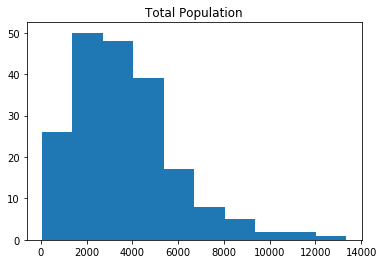

In [33]:
plt.hist(ao_se['total_population'])
plt.title('Total Population')

Text(0.5, 1.0, 'Socioeconomic Level')

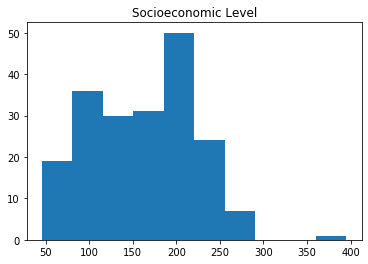

In [34]:
plt.hist(ao_se['socioeconomic_indicator'])
plt.title('Socioeconomic Level')

In [35]:
# ao_se.to_csv('/Users/rogeliomj/Documents/Coursera_Capstone/ao_indic_socioeco.csv', index=False)

## We merge venues and its CVE_AGEB with the socioeconomic indicator database.

In [36]:
venues_agebs = pd.merge(ao_se,v_agebs, left_on='ageb_key',right_on='CVE_AGEB')

In [37]:
venues_agebs.columns

Index(['ageb_key', 'ageb_folium', 'total_population',
       'socioeconomic_indicator', 'Neighborhood', 'Latitude', 'Longitude',
       'Venue', 'Venue Lati', 'Venue Long', 'Venue Cate', 'CVEGEO', 'CVE_AGEB',
       'CVE_ENT', 'CVE_LOC', 'CVE_MUN'],
      dtype='object')

In [38]:
venues_agebs = venues_agebs.loc[:,['total_population','socioeconomic_indicator','Neighborhood','Latitude'
                                   ,'Longitude','Venue','Venue Lati','Venue Long','Venue Cate']]

In [39]:
venues_agebs.head()

,total_population,socioeconomic_indicator,Neighborhood,Latitude,Longitude,Venue,Venue Lati,Venue Long,Venue Cate
0,1775,125.460928,COVE,19.401334,-99.197524,Paleteria y Neveria Lupita,19.401818,-99.199235,Ice Cream Shop
1,1775,125.460928,COVE,19.401334,-99.197524,Las Bolas de Pepe,19.403010,-99.197648,Beer Bar
2,1775,125.460928,COVE,19.401334,-99.197524,Casa Ikeda,19.402740,-99.198812,Furniture / Home Store
3,1775,125.460928,COVE,19.401334,-99.197524,El Surtidor,19.402280,-99.200130,Furniture / Home Store
4,1775,125.460928,COVE,19.401334,-99.197524,Quecas De Lucha,19.400765,-99.197172,Mexican Restaurant


### Bining data to get population and socioeconomic indicator categories

In [40]:
bins = [0, 5000, 10000, 15000]
venues_agebs['total_population'] = pd.cut(venues_agebs['total_population'], 
                                          bins, 
                                         labels=['low_pop_density','medium_pop_density','high_pop_density'])

In [41]:
bins = [0, 150, 250, 400]
venues_agebs['socioeconomic_indicator'] = pd.cut(venues_agebs['socioeconomic_indicator'], 
                                          bins, 
                                          labels=['high_socio_econ_lvl','medium_socio_econ_lvl',
                                                  'low_socioecon_level'])

In [42]:
venues_agebs.head()

,total_population,socioeconomic_indicator,Neighborhood,Latitude,Longitude,Venue,Venue Lati,Venue Long,Venue Cate
0,low_pop_density,high_socio_econ_lvl,COVE,19.401334,-99.197524,Paleteria y Neveria Lupita,19.401818,-99.199235,Ice Cream Shop
1,low_pop_density,high_socio_econ_lvl,COVE,19.401334,-99.197524,Las Bolas de Pepe,19.403010,-99.197648,Beer Bar
2,low_pop_density,high_socio_econ_lvl,COVE,19.401334,-99.197524,Casa Ikeda,19.402740,-99.198812,Furniture / Home Store
3,low_pop_density,high_socio_econ_lvl,COVE,19.401334,-99.197524,El Surtidor,19.402280,-99.200130,Furniture / Home Store
4,low_pop_density,high_socio_econ_lvl,COVE,19.401334,-99.197524,Quecas De Lucha,19.400765,-99.197172,Mexican Restaurant


### Getting dummies from venue catagories, socioeconomic indicator and total population

In [43]:
# one hot encoding
ao_onehot = pd.get_dummies(venues_agebs[['Venue Cate','total_population','socioeconomic_indicator']],
                           prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ao_onehot['Neighborhood'] = venues_agebs['Neighborhood']

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [44]:
ao_grouped = ao_onehot.groupby('Neighborhood').mean().reset_index()
ao_grouped

,Neighborhood,ATM,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,low_pop_density,medium_pop_density,high_pop_density,high_socio_econ_lvl,medium_socio_econ_lvl,low_socioecon_level
0,19 DE MAYO,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1RA VICTORIA,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1RA VICTORIA SECCION BOSQUES,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,26 DE JULIO,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2DA JALALPA TEPITO (AMPL),0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,2DA EL PIRUL (AMPL),0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,ABRAHAM GONZALEZ,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,ACUEDUCTO,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,ACUILOTLA,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,AGUILAS 3ER PARQUE,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.045455,...,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [45]:
ao_grouped_clustering = ao_grouped.drop('Neighborhood', 1)

In [46]:
ao_grouped_clustering = ao_grouped.drop(['Neighborhood',
                                        'low_pop_density',
                                        'medium_pop_density',
                                        'high_pop_density',
                                        'high_socio_econ_lvl',
                                        'medium_socio_econ_lvl',
                                        'low_socioecon_level'], axis=1)

In [47]:
ao_grouped_clustering.head()

,ATM,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,...,Video Store,Warehouse Store,Whisky Bar,Wine Bar,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cluster Neighborhoods

In [48]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ao_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 5, 5, 2, 4, 5, 5, 2, 2, 2], dtype=int32)

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ao_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ao_merged = ao_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ao_merged.head() # check the last columns!

,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALVARO OBREGON,2DA JALALPA TEPITO (AMPL),19.375655,-99.233207,4.0,Soccer Field,Ice Cream Shop,Taco Place,Scenic Lookout,Fabric Shop,Electronics Store,Embassy / Consulate,Entertainment Service,Event Space,Zoo Exhibit
1,ALVARO OBREGON,ESTADO DE HIDALGO_,19.364444,-99.241681,1.0,Taco Place,Coffee Shop,Burger Joint,Soccer Field,Zoo Exhibit,Electronics Store,Floating Market,Flea Market,Fish Market,Fast Food Restaurant
2,ALVARO OBREGON,SAN CLEMENTE,19.349309,-99.226218,1.0,Convenience Store,Gym,Bakery,Pool,Road,Pizza Place,Diner,Drugstore,Electronics Store,Ski Area
3,ALVARO OBREGON,VILLA SOLIDARIDAD,19.383402,-99.219292,1.0,Seafood Restaurant,River,Mexican Restaurant,Zoo Exhibit,Drugstore,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Farm
4,ALVARO OBREGON,TEPOPOTLA,19.362128,-99.251763,5.0,Convenience Store,Department Store,Burger Joint,Farmers Market,Garden,Taco Place,Gym,Dessert Shop,Donut Shop,Restaurant


In [50]:
ao_merged.dropna(inplace=True)
ao_merged['Cluster Labels'] = ao_merged['Cluster Labels'].astype(int)

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="OpenStreetMap")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ao_merged['Latitude'], ao_merged['Longitude'], ao_merged['Neighborhood'],
                                  ao_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [52]:
# add clustering labels
ao_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [53]:
ao_grouped = pd.merge(ao_grouped,neighborhoods, on=['Neighborhood'], how='inner')

# Cluster analysis

### Cluster 0

In [54]:
ao_grouped['Cluster Labels'].unique()

array([2, 5, 4, 1, 0, 3])

In [55]:
cl0 = ao_grouped[ao_grouped['Cluster Labels'] == 0]

#### Dataframe only with venues

In [56]:
cl0_venues = cl0.drop(['low_pop_density',
                           'medium_pop_density','high_pop_density',
                           'high_socio_econ_lvl','medium_socio_econ_lvl',
                           'low_socioecon_level','District','Latitude',
                           'Longitude','Cluster Labels'], axis=1)


In [57]:
num_top_venues = 10

for hood in cl0_venues['Neighborhood']:
    print("----"+hood+"----")
    temp = cl0_venues[cl0_venues['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ARCOS DE CENTENARIO----
                Venue  freq
0         Pizza Place  0.19
1        Burger Joint  0.12
2  Mexican Restaurant  0.12
3   Electronics Store  0.06
4    Stationery Store  0.06
5      Breakfast Spot  0.06
6          Taco Place  0.06
7            Pharmacy  0.06
8         Coffee Shop  0.06
9       Shopping Mall  0.06


----AVE REAL (AMPL)----
                   Venue  freq
0           Burger Joint  0.29
1    American Restaurant  0.14
2                    Gym  0.14
3         Scenic Lookout  0.14
4            Pizza Place  0.14
5            Flea Market  0.14
6  Performing Arts Venue  0.00
7              Piano Bar  0.00
8               Pharmacy  0.00
9              Pet Store  0.00


----CANUTILLO 3RA SECCION----
                Venue  freq
0         Pizza Place  0.19
1        Burger Joint  0.12
2  Mexican Restaurant  0.12
3   Electronics Store  0.06
4    Stationery Store  0.06
5      Breakfast Spot  0.06
6          Taco Place  0.06
7            Pharmacy  0.06
8         Cof

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cl0_venues['Neighborhood']

for ind in np.arange(cl0_venues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cl0_venues.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,ARCOS DE CENTENARIO,Pizza Place,Mexican Restaurant,Burger Joint,Stationery Store,Coffee Shop,Pharmacy,Shopping Mall,Electronics Store,Fabric Shop,Breakfast Spot
24,AVE REAL (AMPL),Burger Joint,Gym,Flea Market,Pizza Place,Scenic Lookout,American Restaurant,Flower Shop,Fish Market,Fast Food Restaurant,Electronics Store
40,CANUTILLO 3RA SECCION,Pizza Place,Mexican Restaurant,Burger Joint,Stationery Store,Coffee Shop,Pharmacy,Shopping Mall,Electronics Store,Fabric Shop,Breakfast Spot
41,CANUTILLO PREDIO LA PRESA,Pizza Place,Taco Place,Pharmacy,Mexican Restaurant,Fabric Shop,Convenience Store,Burger Joint,Fast Food Restaurant,Farmers Market,Fish Market
42,CANUTILLO(AGUASCALIENTES),Pizza Place,Burger Joint,Mexican Restaurant,Zoo Exhibit,Embassy / Consulate,Fondue Restaurant,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant
47,COLINAS DEL SUR,Pizza Place,Mexican Restaurant,Burger Joint,Gym Pool,Sushi Restaurant,Electronics Store,Seafood Restaurant,Bar,Gym,Convenience Store
67,EL PIRU (FRACC),Taco Place,Pizza Place,Zoo Exhibit,Electronics Store,Fondue Restaurant,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
83,GOLONDRINAS,Pizza Place,Athletics & Sports,Southern / Soul Food Restaurant,Market,Taco Place,Pharmacy,Food Truck,Farmers Market,Farm,Electronics Store
90,HERON PROAL,Pizza Place,Convenience Store,Seafood Restaurant,Rental Car Location,Burger Joint,Taco Place,Fabric Shop,Mexican Restaurant,Pharmacy,Diner
116,LA PERA XOCHINAHUAC (U HAB),Burger Joint,Pizza Place,Convenience Store,Seafood Restaurant,Rental Car Location,Taco Place,Fabric Shop,Mexican Restaurant,Pharmacy,Stationery Store


#### Dataframe only with population indicators

In [60]:
cl0_pop_indicators = cl0.loc[:,['Neighborhood','low_pop_density',
                           'medium_pop_density','high_pop_density']]

In [61]:
num_top_pops = 3

for hood in cl0_pop_indicators['Neighborhood']:
    print("----"+hood+"----")
    temp = cl0_pop_indicators[cl0_pop_indicators['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_pops))
    print('\n')

----ARCOS DE CENTENARIO----
                Venue  freq
0  medium_pop_density   1.0
1     low_pop_density   0.0
2    high_pop_density   0.0


----AVE REAL (AMPL)----
                Venue  freq
0     low_pop_density   1.0
1  medium_pop_density   0.0
2    high_pop_density   0.0


----CANUTILLO 3RA SECCION----
                Venue  freq
0     low_pop_density   1.0
1  medium_pop_density   0.0
2    high_pop_density   0.0


----CANUTILLO PREDIO LA PRESA----
                Venue  freq
0     low_pop_density   1.0
1  medium_pop_density   0.0
2    high_pop_density   0.0


----CANUTILLO(AGUASCALIENTES)----
                Venue  freq
0     low_pop_density   1.0
1  medium_pop_density   0.0
2    high_pop_density   0.0


----COLINAS DEL SUR----
                Venue  freq
0     low_pop_density   1.0
1  medium_pop_density   0.0
2    high_pop_density   0.0


----EL PIRU (FRACC)----
                Venue  freq
0     low_pop_density   1.0
1  medium_pop_density   0.0
2    high_pop_density   0.0


----

In [62]:
def return_most_common_pops(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [63]:
num_top_pops = 2

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_pops):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_pops_sorted = pd.DataFrame(columns=columns)
neighborhoods_pops_sorted['Neighborhood'] = cl0_pop_indicators['Neighborhood']

for ind in np.arange(cl0_venues.shape[0]):
    neighborhoods_pops_sorted.iloc[ind, 1:] = return_most_common_pops(cl0_pop_indicators.iloc[ind, :],
                                                                          num_top_pops)

neighborhoods_pops_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
17,ARCOS DE CENTENARIO,medium_pop_density,high_pop_density
24,AVE REAL (AMPL),low_pop_density,high_pop_density
40,CANUTILLO 3RA SECCION,low_pop_density,high_pop_density
41,CANUTILLO PREDIO LA PRESA,low_pop_density,high_pop_density
42,CANUTILLO(AGUASCALIENTES),low_pop_density,high_pop_density
47,COLINAS DEL SUR,low_pop_density,high_pop_density
67,EL PIRU (FRACC),low_pop_density,high_pop_density
83,GOLONDRINAS,low_pop_density,high_pop_density
90,HERON PROAL,low_pop_density,high_pop_density
116,LA PERA XOCHINAHUAC (U HAB),medium_pop_density,high_pop_density


#### Dataframe only with socioeconomic indicators

In [64]:
cl0_indicators = cl0.loc[:,['Neighborhood','high_socio_econ_lvl','medium_socio_econ_lvl','low_socioecon_level']]

In [65]:
num_top_inds = 2

for hood in cl0_indicators['Neighborhood']:
    print("----"+hood+"----")
    temp = cl0_indicators[cl0_indicators['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_pops))
    print('\n')

----ARCOS DE CENTENARIO----
                   Venue  freq
0    high_socio_econ_lvl   1.0
1  medium_socio_econ_lvl   0.0


----AVE REAL (AMPL)----
                   Venue  freq
0  medium_socio_econ_lvl   1.0
1    high_socio_econ_lvl   0.0


----CANUTILLO 3RA SECCION----
                   Venue  freq
0    high_socio_econ_lvl   1.0
1  medium_socio_econ_lvl   0.0


----CANUTILLO PREDIO LA PRESA----
                   Venue  freq
0    high_socio_econ_lvl   1.0
1  medium_socio_econ_lvl   0.0


----CANUTILLO(AGUASCALIENTES)----
                   Venue  freq
0  medium_socio_econ_lvl   1.0
1    high_socio_econ_lvl   0.0


----COLINAS DEL SUR----
                   Venue  freq
0    high_socio_econ_lvl   1.0
1  medium_socio_econ_lvl   0.0


----EL PIRU (FRACC)----
                   Venue  freq
0  medium_socio_econ_lvl   1.0
1    high_socio_econ_lvl   0.0


----GOLONDRINAS----
                   Venue  freq
0  medium_socio_econ_lvl   1.0
1    high_socio_econ_lvl   0.0


----HERON PROAL----
  

In [66]:
def return_most_common_inds(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_inds = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_inds):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_inds_sorted = pd.DataFrame(columns=columns)
neighborhoods_inds_sorted['Neighborhood'] = cl0_indicators['Neighborhood']

for ind in np.arange(cl0_venues.shape[0]):
    neighborhoods_inds_sorted.iloc[ind, 1:] = return_most_common_inds(cl0_indicators.iloc[ind, :],
                                                                          num_top_inds)

neighborhoods_inds_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
17,ARCOS DE CENTENARIO,high_socio_econ_lvl,low_socioecon_level,medium_socio_econ_lvl
24,AVE REAL (AMPL),medium_socio_econ_lvl,low_socioecon_level,high_socio_econ_lvl
40,CANUTILLO 3RA SECCION,high_socio_econ_lvl,low_socioecon_level,medium_socio_econ_lvl
41,CANUTILLO PREDIO LA PRESA,high_socio_econ_lvl,low_socioecon_level,medium_socio_econ_lvl
42,CANUTILLO(AGUASCALIENTES),medium_socio_econ_lvl,low_socioecon_level,high_socio_econ_lvl
47,COLINAS DEL SUR,high_socio_econ_lvl,low_socioecon_level,medium_socio_econ_lvl
67,EL PIRU (FRACC),medium_socio_econ_lvl,low_socioecon_level,high_socio_econ_lvl
83,GOLONDRINAS,medium_socio_econ_lvl,low_socioecon_level,high_socio_econ_lvl
90,HERON PROAL,medium_socio_econ_lvl,low_socioecon_level,high_socio_econ_lvl
116,LA PERA XOCHINAHUAC (U HAB),high_socio_econ_lvl,low_socioecon_level,medium_socio_econ_lvl


In [68]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt 

In [69]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(ao_grouped_clustering)   
      
    distortions.append(sum(np.min(cdist(ao_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / ao_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(ao_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / ao_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [70]:
for key,val in mapping1.items():
    print(str(key)+' : '+str(val))

1 : 0.31338638610944475
2 : 0.2958156636336354
3 : 0.28723275773043616
4 : 0.282721268563677
5 : 0.2784438593841139
6 : 0.27141632998485726
7 : 0.26966661656291585
8 : 0.26413511927340594
9 : 0.25864369388874925


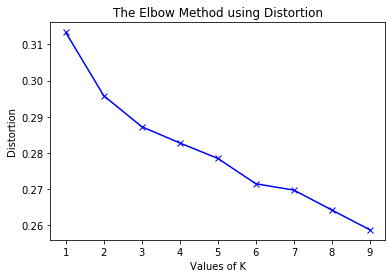

In [71]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 